# Integration of ATAC-seq and RNA-seq using SCREAM

The 10X PBMC dataset is a published SNARE-seq dataset of human peripheral blood mononuclear cells (PBMCs) available for download from the 10x Genomics website (https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k
).

In [1]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import scanpy as sc
import muon as mu
import mudata as md
import matplotlib.pyplot as plt
mu.set_options(pull_on_update=False)

2025-09-04 15:40:02.619216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 15:40:08.636368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 15:40:35.487354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import SCREAM

## Define directories

In [3]:
mainDir = os.getcwd()
inputDir = os.path.join(mainDir, 'inputfiles')
rawDir = os.path.join(inputDir, 'raw')
processedDir = os.path.join(inputDir, 'processed')
results_dir = os.path.join(mainDir, 'results')

## Define global settings

In [4]:
sc.set_figure_params(dpi=100, color_map='viridis_r')
%matplotlib inline

In [5]:
print(f'Time before running script: {datetime.datetime.now().strftime("%d %b %Y %H:%M:%S")}')

Time before running script: 04 Sep 2025 15:41:19


In [6]:
t_start = datetime.datetime.now()

## Read data

This data was pre-processed using Signac in R and converted to h5ad. Refer to https://stuartlab.org/signac/articles/pbmc_multiomic for pre-processing steps.

### Read 10X data

In [7]:
mdata = mu.read_h5mu(os.path.join(processedDir, '10XPBMC_processed.h5mu'))
mdata.push_obs()
display(mdata)

MuData object with n_obs × n_vars = 9966 × 132543
  obs:	'cell_types_anno'
  var:	'modality'
  2 modalities
    RNA:	9966 x 24166
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4.TEM', 'prediction.score.cDC2', 'prediction.score.NK.Proliferating', 'prediction.score.ASDC', 'prediction.score.HSPC', 'prediction.score.Platelet', 'prediction.score.NK_CD56bright', 'prediction.score.CD4.Proliferating', 'prediction.score.Eryth', 'prediction.score.cDC1', 'prediction.score.ILC', 'prediction.score.max', 'SCT.weight', 'ATAC.weight', 'cell_types_anno'
      var:	'modality'
      uns:	'varfeats'
      obsm:	'pca'
      layers:	'raw', 'sct'
    ATAC:	9966 x 108377
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4.TEM', 'prediction.score.cDC2', 'prediction.score.NK.Proliferating', 'prediction.score.ASDC', 'prediction.score.HSPC', 'prediction.score.Platelet', 'prediction.score.NK_CD56bright', 'prediction.score.CD4.Proliferating', 'prediction.score.Eryth', 'prediction.score.cDC1', 'prediction.score.ILC', 'prediction.score.max', 'SCT.weight', 'ATAC.weight', 'cell_types_anno'
      var:	'modality'
      obsm:	'lsi'
      layers:	'lsi', 'raw'

In [8]:
rna_adata = mdata.mod['RNA']
rna_adata.X = rna_adata.layers['sct']
rna_adata = rna_adata[:, rna_adata.uns['varfeats']].copy()
rna_adata.X = rna_adata.X.todense()
display(rna_adata)

/tmp/ipykernel_867580/3727506755.py:4: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  rna_adata.X = rna_adata.X.todense()


AnnData object with n_obs × n_vars = 9966 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4.TEM', 'prediction.score.cDC2', 'prediction.score.NK.Proliferating', 'prediction.score.ASDC', 'prediction.score.HSPC', 'prediction.score

In [9]:
atac_adata = mdata.mod['ATAC']
display(atac_adata)

AnnData object with n_obs × n_vars = 9966 × 108377
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4.TEM', 'prediction.score.cDC2', 'prediction.score.NK.Proliferating', 'prediction.score.ASDC', 'prediction.score.HSPC', 'prediction.sco

In [19]:
del rna_adata.obsp['distances'], rna_adata.obsp['connectivities']
del atac_adata.obsp['distances'], atac_adata.obsp['connectivities']

## Pre-processing

For this dataset, we use the LSIs from Signac as input. The first LSI component often captures sequencing depth (technical variation) rather than biological variation. Therefore, we remove that from the input.

In [31]:
atac_snare_adata = sc.AnnData(mdata.mod['ATAC'].obsm['lsi'][:, 1:], obs=mdata.mod['ATAC'].obs)
display(atac_snare_adata)

AnnData object with n_obs × n_vars = 9966 × 299
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4.TEM', 'prediction.score.cDC2', 'prediction.score.NK.Proliferating', 'prediction.score.ASDC', 'prediction.score.HSPC', 'prediction.score.

## Initialize SCREAM

In [32]:
model_result_dir = os.path.join(results_dir, 'scream_10xpbmc')
scream_model = SCREAM.models.scream.SCREAM({'rna': rna_adata, "atac": atac_snare_adata}, save_dir=model_result_dir, logger=True)

Trained models will be saved at: /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_10xpbmc
MuData object with n_obs × n_vars = 9966 × 3299
  2 modalities
    rna:	9966 x 3000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4

### Stage 1: Train individual modalities

In [33]:
sae_rna = scream_model.pretrain_modality(modality='rna', encoding_layer_dims=[1024, 256], batch_size=128, train_test_split=None, save_encoder=True)

Folder already exists
{'batch_size': 128}


Model: "AE_rna"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_rna (InputLayer)          │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0_rna (Dense)           │ (None, 1024)           │     3,073,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1_rna (Dense)           │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1_rna (Dense)           │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0_rna (Dense)           │ (None, 3000)           │     3,075,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,673,592 (25.46 MB)

 Trainable params: 6,673,592 (25.46 MB)

 Non-trainable params: 0 (0.00 B)

None
Pretraining layer 1...
Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2551 - lr: 0.1000
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2009 - lr: 0.1000
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1903 - lr: 0.1000
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1850 - lr: 0.1000
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1822 - lr: 0.1000
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1802 - lr: 0.1000
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1787 - lr: 0.1000
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1773 - lr: 0.1000
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1761 - lr: 0.1000
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1750 - lr: 0.1000
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1740 - lr: 0.1000
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1730 - lr: 0.1000
Epoch 13/150
78/78 ━

In [34]:
SCREAM.models.tools.plot_architecture(sae_rna.autoencoders, to_file=os.path.join(model_result_dir, 'rna_ae.png'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [36]:
sae_atac = scream_model.pretrain_modality(modality='atac', encoding_layer_dims=[1024, 256], batch_size=128, train_test_split=None, save_encoder=True)

Folder already exists
{'batch_size': 128}


Model: "AE_atac"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_atac (InputLayer)         │ (None, 299)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0_atac (Dense)          │ (None, 1024)           │       307,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1_atac (Dense)          │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1_atac (Dense)          │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0_atac (Dense)          │ (None, 299)            │       306,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,139,243 (4.35 MB)

 Trainable params: 1,139,243 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

None
Pretraining layer 1...
Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0900 - lr: 0.1000
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8652 - lr: 0.1000
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7554 - lr: 0.1000
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7006 - lr: 0.1000
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6675 - lr: 0.1000
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6471 - lr: 0.1000
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6304 - lr: 0.1000
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6198 - lr: 0.1000
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6112 - lr: 0.1000
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6041 - lr: 0.1000
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5983 - lr: 0.1000
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.5944 - lr: 0.1000
Epoch 13/150
78/78

2025-09-04 15:50:27.895323: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


 91/312 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step

2025-09-04 15:50:28.847865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 484 bytes spill stores, 484 bytes spill loads



312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Pretraining layer 2...
Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2694 - lr: 0.1000
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2629 - lr: 0.1000
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2563 - lr: 0.1000
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2496 - lr: 0.1000
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2435 - lr: 0.1000
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2378 - lr: 0.1000
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2324 - lr: 0.1000
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.2272 - lr: 0.1000
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2222 - lr: 0.1000
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2177 - lr: 0.1000
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2130 - lr: 0.1000
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

In [37]:
SCREAM.models.tools.plot_architecture(sae_atac.autoencoders, to_file=os.path.join(model_result_dir, 'atac_ae.png'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [39]:
rna_adata_aftertrain = scream_model.mdata_train.mod['rna']
atac_adata_aftertrain = scream_model.mdata_train.mod['atac']

### Stage 2: Train on joint latent space

In [57]:
default_scream_opts = {'tol': 0.0001, 'n_neighbors': 15,
                       'batch_size': 128, 'method': 'leiden',
                       'do_tsne': True, 'tsne_kwargs': {'learning_rate': 200}, 'gpu_device': None,
                       'save_encoder_weights': False, 'use_ae_weights': False,
                       'do_umap': True, 'save_clustering_model': True}

leiden_res = sorted(set(list(np.linspace(0.1, 1, num=10).round(decimals=2)) + list(np.linspace(0.05, 0.1, num=5).round(decimals=2)) + 
                        list(np.linspace(1, 2, num=5).round(decimals=2))))

In [78]:
ae_combined = scream_model.train_joint(modalities=None, clustering_resolutions=leiden_res, encoding_layer_dims=[1024, 256], max_iter=1000, **default_scream_opts)

Folder already exists
{'tol': 0.0001, 'n_neighbors': 15, 'batch_size': 128, 'method': 'leiden', 'save_encoder_weights': False, 'use_ae_weights': False}
{'learning_rate': 200}
The number of available cores is 128.
The number of cores used for training is 10.
Start to process resolution: 1.0
Training will be done on CPU.
Runtime for resolution 1.0 (HH:MM:SS): 0:00:00.000005
Rerunning autoencoder
Logged at /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_10xpbmc/rna_atac_joint/pretrain
Pretraining layer 1...
Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1986 - lr: 0.1000
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1297 - lr: 0.1000
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1163 - lr: 0.1000
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1092 - lr: 0.1000
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1044 - lr: 0.1000
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1009 - lr: 0.1000
Epoch

/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.17178407311439514 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0536   
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0474  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0443  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0417  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0395  
The value of delta_label of current 2th iteration is: 0.08870158344507217 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0912  
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0841  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0781  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0726  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0674  
The value of delta_label of current 3th iteration is: 0.15653221309185028 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1278  
Epoch 2/

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 17)             │         4,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,584,130 (6.04 MB)

 Trainable params: 792,064 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 792,066 (3.02 MB)

UMAP finished and added X_umap1.0 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne1.0 into adata.obsm

Start to process resolution: 1.25
Training will be done on CPU.
Runtime for resolution 1.25 (HH:MM:SS): 0:00:00.000008
Pretraining time (HH:MM:SS): 0:00:00.032314
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.17810556292533875 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0573   
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0509  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0476  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0450  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0427
The value of delta_label of current 2th iteration is: 0.09381898492574692 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0958  
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0884  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0820  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0761  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0708
The value of delta_label of current 3th iteration is: 0.14429058134555817 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.1334
Epoch 2/

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 18)             │         4,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,584,642 (6.04 MB)

 Trainable params: 792,320 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 792,322 (3.02 MB)

UMAP finished and added X_umap1.25 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne1.25 into adata.obsm

Start to process resolution: 1.5
Training will be done on CPU.
Runtime for resolution 1.5 (HH:MM:SS): 0:00:00.000010
Pretraining time (HH:MM:SS): 0:00:00.034876
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.17710214853286743 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0579   
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0520  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0490  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0466  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0445  
The value of delta_label of current 2th iteration is: 0.0822797492146492 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0935
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0872  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0818
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0767  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.0720
The value of delta_label of current 3th iteration is: 0.13626329600811005 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1266  
Epoch 2/5

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 20)             │         5,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,585,666 (6.05 MB)

 Trainable params: 792,832 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 792,834 (3.02 MB)

UMAP finished and added X_umap1.5 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne1.5 into adata.obsm

Start to process resolution: 1.75
Training will be done on CPU.
Runtime for resolution 1.75 (HH:MM:SS): 0:00:00.000016
Pretraining time (HH:MM:SS): 0:00:00.026936
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step    
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.18663455545902252 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0577 
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0517  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0487  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0463  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0441  
The value of delta_label of current 2th iteration is: 0.08639373630285263 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0938  
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0875  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0820  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0769  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0721  
The value of delta_label of current 3th iteration is: 0.12362030893564224 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1267  
Epoch 2/5


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 20)             │         5,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,585,666 (6.05 MB)

 Trainable params: 792,832 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 792,834 (3.02 MB)

UMAP finished and added X_umap1.75 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne1.75 into adata.obsm

Start to process resolution: 2.0
Training will be done on CPU.
Runtime for resolution 2.0 (HH:MM:SS): 0:00:00.000014
Pretraining time (HH:MM:SS): 0:00:00.037919
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step    
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.19275537133216858 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0565   
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0514  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0488  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0468  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0450  
The value of delta_label of current 2th iteration is: 0.08448725938796997 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0881  
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0832  
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0789  
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0748  
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0709  
The value of delta_label of current 3th iteration is: 0.12442304193973541 >= tol 0.0001
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1155  
Epoch 2/

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 23)             │         5,888 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,587,202 (6.05 MB)

 Trainable params: 793,600 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 793,602 (3.03 MB)

UMAP finished and added X_umap2.0 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne2.0 into adata.obsm

Total time to run DESC (HH:MM:SS): 0:14:55.872875
MuData object with n_obs × n_vars = 9966 × 3299
  obs:	'desc_0.05', 'desc_0.06', 'desc_0.08', 'desc_0.09', 'desc_0.1', 'desc_0.2', 'desc_0.3', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9', 'desc_1.0', 'leiden', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'desc_1.25', 'desc_1.5', 'desc_1.75', 'desc_2.0'
  uns:	'prob_matrix0.05', 'umap', 'tsne', 'prob_matrix0.06', 'prob_matrix0.08', 'prob_matrix0.09', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.3', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8', 'prob_matrix0.9', 'prob_matrix1.0', 'desc_0.2_colors', 'desc_1.0_colors', 'desc_0.9_colors', 'leiden', 'leiden_1.0_colors', 'leiden_0.6_colors', 'prob_matrix1.25', 'prob_matrix1.5', 'prob_matrix1.75', 'prob_matrix2.0'
  obsm:	'joi

In [35]:
SCREAM.models.tools.plot_architecture(ae_combined.model, to_file=os.path.join(model_result_dir, 'joint_ae.png'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Plot cluster evaluation metrics

In [79]:
leiden_res = sorted(set(list(np.linspace(0.1, 1, num=10).round(decimals=2)) + list(np.linspace(0.05, 0.1, num=5).round(decimals=2)) + 
                        list(np.linspace(1, 2, num=5).round(decimals=2))))

In [80]:
ari_pd = SCREAM.models.tools.calc_ari(scream_model.mdata_train, label_col='rna:cell_types_anno', cluster_res=leiden_res)
nmi_pd = SCREAM.models.tools.calc_nmi(scream_model.mdata_train, label_col='rna:cell_types_anno', cluster_res=leiden_res)
sil_pd = SCREAM.models.tools.calc_silhouette(scream_model.mdata_train, cluster_res=leiden_res)
metrics_df = ari_pd.join([nmi_pd, sil_pd])

{}


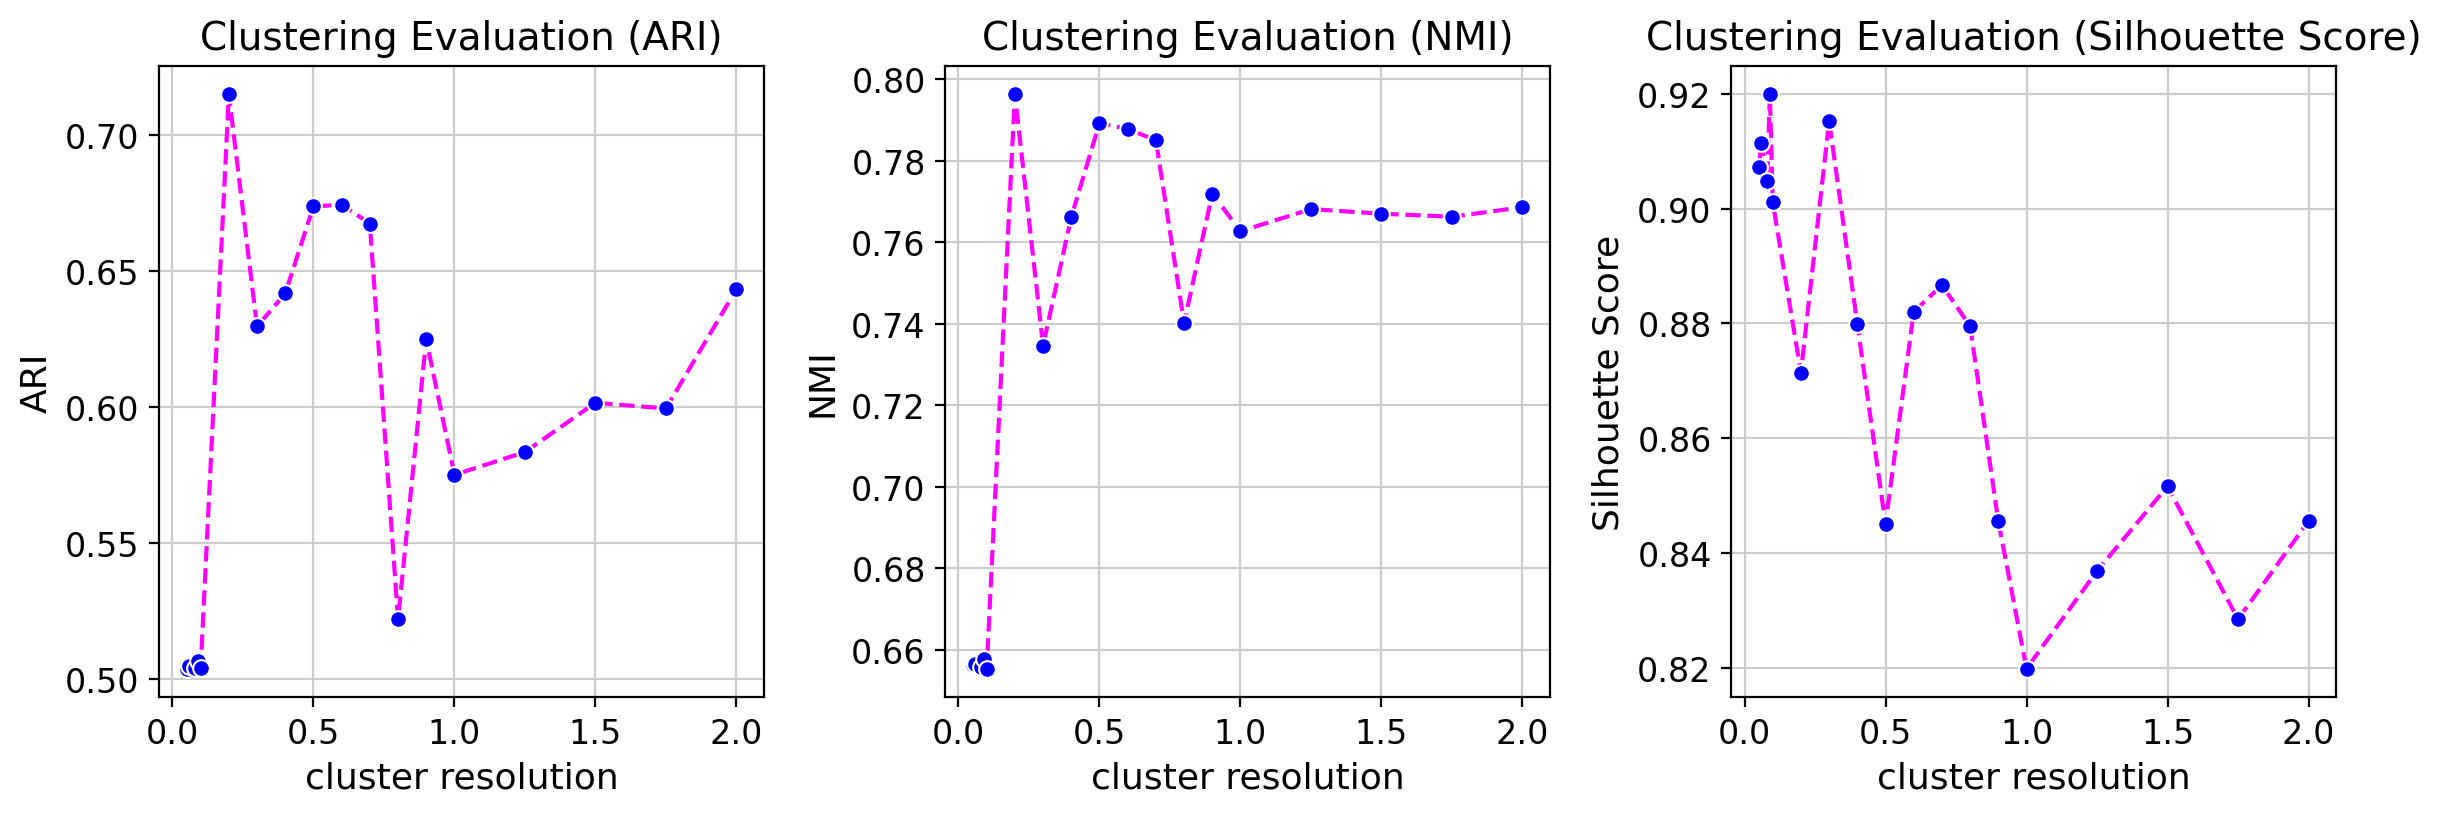

In [81]:
fig = SCREAM.models.tools.plot_clustereval(metrics_df, res_col='cluster resolution', met_cols=None, ncols=5, figsize=None)

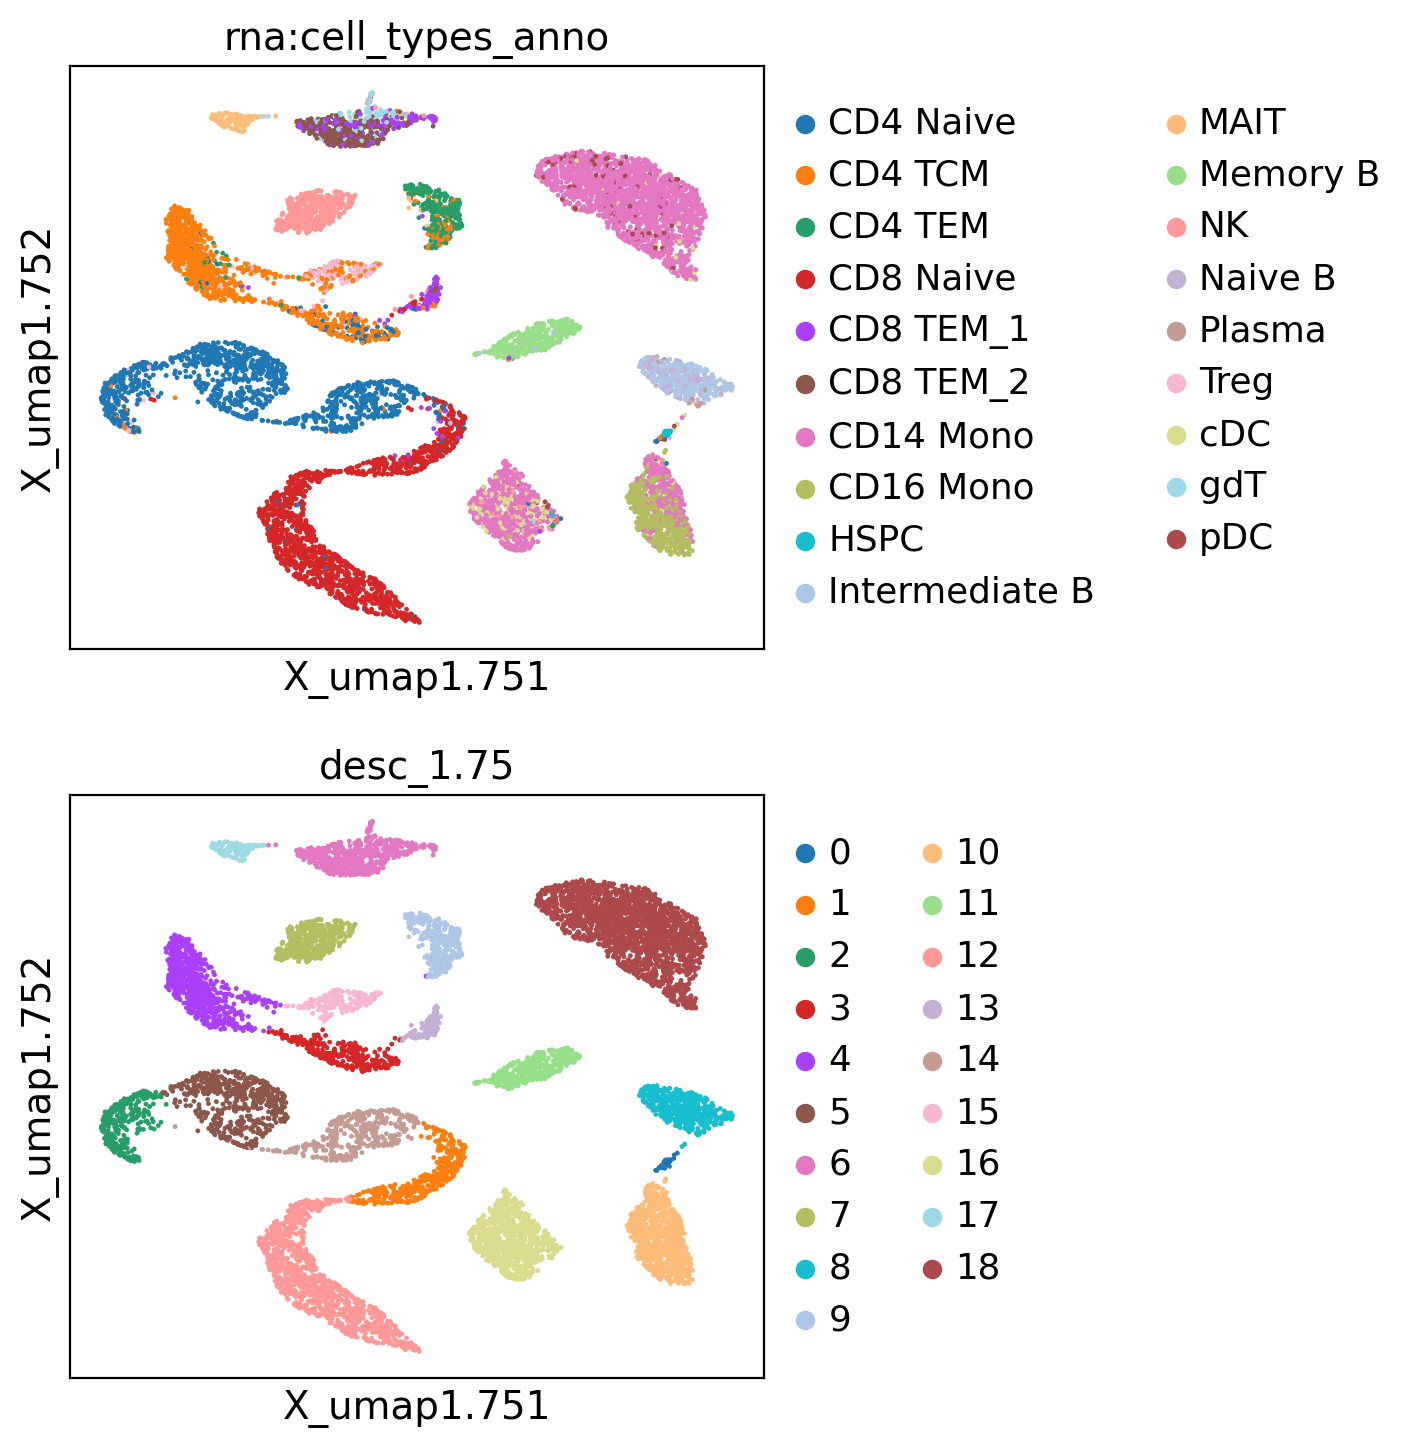

In [89]:
fig = mu.pl.embedding(scream_model.mdata_train, basis='X_umap1.75', color=['rna:cell_types_anno', 'desc_1.75'], ncols=1)

In [43]:
print(f'Time to run script (HH:MM:SS): {str(datetime.datetime.now() - t_start)}')

Time to run script (HH:MM:SS): 0:27:56.643813


In [91]:
scream_model.mdata_train.write_h5mu(os.path.join(processedDir, 'scream_10xpbmc_atac.h5mu'))